In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv
/kaggle/input/amexfeather/test_data_f32.ftr
/kaggle/input/amexfeather/train_data.ftr
/kaggle/input/amexfeather/train_data_f32.ftr
/kaggle/input/amexfeather/test_data.ftr


In [2]:
!pip install scikit-learn

!pip install seaborn

!pip install pyarrow

!pip install lightgbm

!pip install xgboost

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gc

import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amex-default-prediction/sample_submission.csv
/kaggle/input/amex-default-prediction/train_data.csv
/kaggle/input/amex-default-prediction/test_data.csv
/kaggle/input/amex-default-prediction/train_labels.csv
/kaggle/input/amexfeather/test_data_f32.ftr
/kaggle/input/amexfeather/train_data.ftr
/kaggle/input/amexfeather/train_data_f32.ftr
/kaggle/input/amexfeather/test_data.ftr


In [4]:
train_feather_dataset = pd.read_feather('../input/amexfeather/train_data.ftr')

train_dataset = train_feather_dataset.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()

del train_feather_dataset

gc.collect()

0

In [5]:
test_feather_dataset = pd.read_feather('../input/amexfeather/test_data.ftr')

test_dataset = test_feather_dataset.groupby('customer_ID').tail(1).set_index('customer_ID', drop=True).sort_index()

del test_feather_dataset

gc.collect()

0

In [6]:
cat_cols = ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68']

num_cols = [col for col in train_dataset.columns if col not in cat_cols + ["target"]]


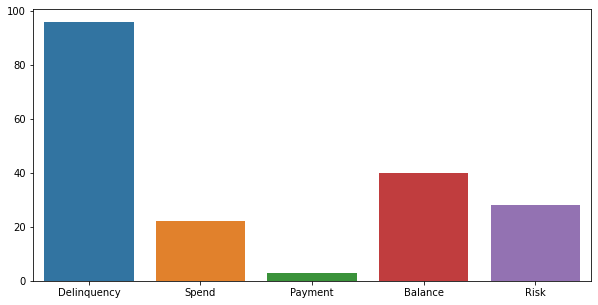

In [7]:
Delinquency = [d for d in train_dataset.columns if d.startswith('D_')]
Spend = [s for s in train_dataset.columns if s.startswith('S_')]
Payment = [p for p in train_dataset.columns if p.startswith('P_')]
Balance = [b for b in train_dataset.columns if b.startswith('B_')]
Risk = [r for r in train_dataset.columns if r.startswith('R_')]
Dict = {'Delinquency': len(Delinquency), 'Spend': len(Spend), 'Payment': len(Payment), 'Balance': len(Balance), 'Risk': len(Risk),}

plt.figure(figsize=(10,5))
sns.barplot(x=list(Dict.keys()), y=list(Dict.values()));

In [8]:
NaN_Val = np.array(train_dataset.isnull().sum())
NaN_prec = np.array((train_dataset.isnull().sum() * 100 / len(train_dataset)).round(2))
NaN_Col = pd.DataFrame([np.array(list(train_dataset.columns)).T,NaN_Val.T,NaN_prec.T,np.array(list(train_dataset.dtypes)).T], index=['Features','Num of Missing values','Percentage','DataType']
).transpose()
pd.set_option('display.max_rows', None)
NaN_Col

,Features,Num of Missing values,Percentage,DataType
0,S_2,0,0.0,datetime64[ns]
1,P_2,2969,0.65,float16
2,D_39,0,0.0,float16
3,B_1,0,0.0,float16
4,B_2,31,0.01,float16
5,R_1,0,0.0,float16
6,S_3,84970,18.52,float16
7,D_41,31,0.01,float16
8,B_3,31,0.01,float16
9,D_42,399003,86.95,float16


In [9]:
NaN_Val2 = np.array(test_dataset.isnull().sum())
NaN_prec2 = np.array((test_dataset.isnull().sum() * 100 / len(test_dataset)).round(2))
NaN_Col2 = pd.DataFrame([np.array(list(test_dataset.columns)).T,NaN_Val2.T,NaN_prec2.T,np.array(list(test_dataset.dtypes)).T], index=['Features','Num of Missing values','Percentage','DataType']
).transpose()
pd.set_option('display.max_rows', None)

NaN_Col2

,Features,Num of Missing values,Percentage,DataType
0,S_2,0,0.0,datetime64[ns]
1,P_2,4784,0.52,float16
2,D_39,0,0.0,float16
3,B_1,0,0.0,float16
4,B_2,43,0.0,float16
5,R_1,0,0.0,float16
6,S_3,144280,15.6,float16
7,D_41,43,0.0,float16
8,B_3,43,0.0,float16
9,D_42,827578,89.5,float16


In [10]:
train_dataset = train_dataset.drop(['S_2','D_66','D_42','D_49','D_73','D_76','R_9','B_29','D_87','D_88','D_106','R_26','D_108','D_110','D_111','B_39','B_42','D_132','D_134','D_135','D_136','D_137','D_138','D_142'], axis=1)

test_dataset = test_dataset.drop(['S_2','D_42','D_49','D_66','D_73','D_76','R_9','B_29','D_87','D_88','D_106','R_26','D_108','D_110','D_111','B_39','B_42','D_132','D_134','D_135','D_136','D_137','D_138','D_142'], axis=1)

In [11]:
selected_column = np.array(['P_2','S_3','B_2','D_41','D_43','B_3','D_44','D_45','D_46','D_48','D_50','D_53','S_7','D_56','S_9','B_6','B_8','D_52','P_3','D_54','D_55','B_13','D_59','D_61','B_15','D_62','B_16','B_17','D_77','B_19','B_20','D_69','B_22','D_70','D_72','D_74','R_7','B_25','B_26','D_78','D_79','D_80','B_27','D_81','R_12','D_82','D_105','S_27','D_83','R_14','D_84','D_86','R_20','B_33','D_89','D_91','S_22','S_23','S_24','S_25','S_26','D_102','D_103','D_104','D_107','B_37','R_27','D_109','D_112','B_40','D_113','D_115','D_118','D_119','D_121','D_122','D_123','D_124','D_125','D_128','D_129','B_41','D_130','D_131','D_133','D_139','D_140','D_141','D_143','D_144','D_145'])

for column in selected_column:
    train_dataset[column] = train_dataset[column].fillna(train_dataset[column].median())
    test_dataset[column] = test_dataset[column].fillna(test_dataset[column].median())

In [12]:
selected_column = np.array(['D_68','B_30','B_38','D_64','D_114','D_116','D_117','D_120','D_126'])

for column in selected_column:
    train_dataset[column] =  train_dataset[column].fillna(train_dataset[column].mode()[0])
    test_dataset[column] =  test_dataset[column].fillna(test_dataset[column].mode()[0])

In [13]:
from sklearn.preprocessing import OrdinalEncoder

enc = OrdinalEncoder()
cat_cols.remove('D_66')

train_dataset[cat_cols] = enc.fit_transform(train_dataset[cat_cols])
test_dataset[cat_cols] = enc.transform(test_dataset[cat_cols])

In [14]:
train_dataset_without_target = train_dataset.drop(["target"],axis=1)

cor_matrix = train_dataset_without_target.corr()
col_core = set()

for i in range(len(cor_matrix.columns)):
    for j in range(i):
        if(cor_matrix.iloc[i, j] > 0.9):
            col_name = cor_matrix.columns[i]
            col_core.add(col_name)
col_core

{'B_11',
 'B_13',
 'B_15',
 'B_23',
 'B_33',
 'B_37',
 'D_104',
 'D_119',
 'D_141',
 'D_143',
 'D_74',
 'D_75',
 'D_77',
 'S_24',
 'S_7'}

In [15]:
train_dataset = train_dataset.drop(col_core, axis=1)
test_dataset = test_dataset.drop(col_core, axis=1)

In [16]:
num_columns = [col for col in train_dataset.columns if col not in ["target"]]

X = train_dataset[num_columns]
y = train_dataset['target']

In [17]:
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
from sklearn.preprocessing import StandardScaler

scaler2 = StandardScaler()
scaler2.fit(X.copy())
X_scaled = scaler2.transform(X.copy())

scaler2.fit(test_dataset.copy())
test_data_scaled = scaler2.transform(test_dataset.copy())
pd.DataFrame(test_data_scaled).head()

,0,1,2,3,4,5,6,7,8,9,...,140,141,142,143,144,145,146,147,148,149
0,-0.264481,-0.221430,-0.565020,0.997483,-0.353858,-0.370347,-0.320700,-0.598378,-0.765401,-0.495423,...,-0.850619,-0.130131,-0.555064,-0.401338,-0.271711,0.196260,-0.456779,-0.181259,-0.263812,-0.305828
1,0.748918,-0.208513,-0.538985,0.995118,-0.343817,-0.569564,-0.301442,-0.568288,-0.265519,-0.505957,...,-0.868245,-0.128274,-0.563667,-0.381320,-0.289410,0.194551,-0.460913,-0.183770,-0.282754,-0.282990
2,0.214977,-0.524029,-0.606923,0.513881,-0.369351,-0.280862,-0.305777,-0.550703,-0.218458,-0.509476,...,-0.851915,-0.129215,1.799628,-0.400805,-0.293062,-0.194059,2.167087,-0.131305,2.233856,0.139147
3,-0.471519,0.296966,0.060477,-0.949636,-0.370587,-0.200522,-0.302697,1.309381,0.375952,0.543706,...,-0.852316,-0.144887,-0.544374,-0.395925,-0.256025,-0.094903,2.185112,-0.164902,2.471553,0.594747
4,-1.434066,1.427447,1.926476,-1.355643,1.432039,-0.269105,-0.290502,2.591037,-0.404999,1.027395,...,1.167653,-0.137767,-0.558746,-0.401261,-0.263271,0.219340,-0.454908,-0.181982,-0.275547,-0.319327


K-nearest neighbors 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

knn = KNeighborsClassifier(n_neighbors=130)
  
knn.fit(X, y)

predictions = knn.predict(test_dataset[num_columns])


sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions})
output.to_csv('KNN.csv', index=False)

Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

Decision_Tree_model = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=42)

Decision_Tree_model.fit(X_scaled, y)

predictions = Decision_Tree_model.predict(test_data_scaled)

sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions})
output.to_csv('Decision_Tree.csv', index=False)

Support vector machine

In [ ]:
from sklearn.svm import LinearSVC

SVM_model = LinearSVC(C=0.1).fit(X, y)

predictions = SVM_model.predict(test_dataset[num_columns])

sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions})
output.to_csv('SVM.csv', index=False)

LightGBM classifier

In [20]:
import lightgbm as lgb

d_train = lgb.Dataset(x_train, label=y_train, categorical_feature = cat_cols)

params = {'objective': 'binary','n_estimators': 1200,'metric': 'binary_logloss','boosting': 'gbdt','num_leaves': 90,'reg_lambda' : 50,'colsample_bytree': 0.19,'learning_rate': 0.03,'min_child_samples': 2400,'max_bins': 511,'seed': 42,'verbose': -1}

lgb_model = lgb.train(params, d_train, 100)

predictions = lgb_model.predict(test_dataset[num_columns])

sample_dataset = pd.read_csv('/kaggle/input/amex-default-prediction/sample_submission.csv')
output = pd.DataFrame({'customer_ID': sample_dataset.customer_ID, 'prediction': predictions})
output.to_csv('LIGHT GBM.csv', index=False)